# 1. Description of the Data and the Predicted Variable

The analyzed data contains information about six different airlines over a span of fifteen years. Below is a detailed description of the variables:

- **Year** - The year of observation.
- **AirlineID** - The ID of the airline.
- **TotalCost** - The total cost.
- **Output** - Production, measured in passenger miles. The size of production can affect costs through economies of scale. A larger scale of operations may allow for the distribution of fixed costs over a greater number of production units, thereby reducing average costs.
- **FuelPrice** - The price of fuel. It directly influences operational costs. Changes in fuel prices can significantly impact airline costs, as fuel is one of the main components of operating expenses.
- **LoadFactor** - Fleet utilization rate. This indicator shows how effectively an airline is using its fleet. A higher load factor indicates better utilization of passenger space and potentially lower costs per unit of production.

The predicted variable is the total cost (**TotalCost**).


# 2.  Loading and preparing the data

In [217]:
library(MASS)
library(leaps)
library(caret)
library(nlme)
library(e1071)
library(randtests)
library(tseries)
library(lmtest)

In [218]:
# Load the data from the CSV file
data <- read.csv("C:/Users/barte/OneDrive/Pulpit/north/PanelData.csv")

In [219]:
# Rename columns for better readability
colnames(data) <- c("AirlineID", "Year", "TotalCost", "Output", "FuelPrice", "LoadFactor")

In [220]:
# Display the first few rows and summary statistics
head(data)
summary(data)

,AirlineID,Year,TotalCost,Output,FuelPrice,LoadFactor
,<int>,<int>,<int>,<dbl>,<int>,<dbl>
1,1,1,1140640,0.952757,106650,0.534487
2,1,2,1215690,0.986757,110307,0.532328
3,1,3,1309570,1.091980,110574,0.547736
4,1,4,1511530,1.175780,121974,0.540846
5,1,5,1676730,1.160170,196606,0.591167
6,1,6,1823740,1.173760,265609,0.575417


   AirlineID        Year      TotalCost           Output       
 Min.   :1.0   Min.   : 1   Min.   :  68978   Min.   :0.03768  
 1st Qu.:2.0   1st Qu.: 4   1st Qu.: 292046   1st Qu.:0.14213  
 Median :3.5   Median : 8   Median : 637001   Median :0.30503  
 Mean   :3.5   Mean   : 8   Mean   :1122524   Mean   :0.54499  
 3rd Qu.:5.0   3rd Qu.:12   3rd Qu.:1345968   3rd Qu.:0.94528  
 Max.   :6.0   Max.   :15   Max.   :4748320   Max.   :1.93646  
   FuelPrice         LoadFactor    
 Min.   : 103795   Min.   :0.4321  
 1st Qu.: 129848   1st Qu.:0.5288  
 Median : 357434   Median :0.5661  
 Mean   : 471683   Mean   :0.5605  
 3rd Qu.: 849840   3rd Qu.:0.5947  
 Max.   :1015610   Max.   :0.6763  

In [221]:
# Check for missing values in each column
sum(is.na(data$AirlineID))
sum(is.na(data$Year))
sum(is.na(data$TotalCost))
sum(is.na(data$Output))
sum(is.na(data$FuelPrice))
sum(is.na(data$LoadFactor))

[1] 0

[1] 0

[1] 0

[1] 0

[1] 0

[1] 0

In [266]:
# Set seed for reproducibility
set.seed(155)

## Data Splitting into Training and Test Sets

The data was divided in a 4:1 ratio for the training set. An equal number of observations were randomly selected for each airline (a total of 20% of the original dataset) for the test set.


In [267]:
# Initialize empty data frames for training and testing datasets
train_df <- data.frame()
test_df <- data.frame()

In [268]:
# Loop through each unique airline ID to create training and testing datasets
for(airline in unique(data$AirlineID)) {
  airline_data <- data[data$AirlineID == airline, ]
  train_indices <- sample(1:nrow(airline_data), size = floor(0.8 * nrow(airline_data)))
  train_subset <- airline_data[train_indices, ]
  train_df <- rbind(train_df, train_subset)
  test_subset <- airline_data[-train_indices, ]
  test_df <- rbind(test_df, test_subset)
}

In [269]:
# Replace original data with the training dataset
data <- train_df
test <- test_df

In [270]:
# Display summary statistics for the training data
summary(data)

   AirlineID        Year          TotalCost           Output       
 Min.   :1.0   Min.   : 1.000   Min.   :  68978   Min.   :0.03768  
 1st Qu.:2.0   1st Qu.: 4.250   1st Qu.: 309315   1st Qu.:0.14213  
 Median :3.5   Median : 8.000   Median : 655080   Median :0.30503  
 Mean   :3.5   Mean   : 8.148   Mean   :1164278   Mean   :0.56730  
 3rd Qu.:5.0   3rd Qu.:12.000   3rd Qu.:1492890   3rd Qu.:1.06899  
 Max.   :6.0   Max.   :15.000   Max.   :4282880   Max.   :1.82544  
   FuelPrice         LoadFactor     log_TotalCost   sqrt_TotalCost  
 Min.   : 110574   Min.   :0.4321   Min.   :11.14   Min.   : 262.6  
 1st Qu.: 145606   1st Qu.:0.5290   1st Qu.:12.64   1st Qu.: 556.2  
 Median : 355845   Median :0.5681   Median :13.39   Median : 809.3  
 Mean   : 481761   Mean   :0.5626   Mean   :13.39   Mean   : 947.7  
 3rd Qu.: 847450   3rd Qu.:0.6029   3rd Qu.:14.22   3rd Qu.:1221.8  
 Max.   :1015610   Max.   :0.6763   Max.   :15.27   Max.   :2069.5  

# 3. Selection of Variables for the Model


## 3.1. Information Capacity Index (ICA) Method

To select variables using this method, the variables **R0** and **R** were created.
- **R0** is the vector of correlations of each dependent variable with the independent variable.
- **R** is the correlation matrix among the explanatory variables.


In [271]:
# Build a full model with all potential explanatory variables
full_model <- lm(TotalCost ~ FuelPrice + LoadFactor + Output + AirlineID + Year, data = data)
summary(full_model)


Call:
lm(formula = TotalCost ~ FuelPrice + LoadFactor + Output + AirlineID + 
    Year, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-528938 -218976   25497  182961  826388 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.027e+06  6.196e+05   1.658  0.10392    
FuelPrice    7.728e-01  3.341e-01   2.313  0.02505 *  
LoadFactor  -3.152e+06  1.022e+06  -3.086  0.00337 ** 
Output       2.114e+06  1.725e+05  12.253  < 2e-16 ***
AirlineID    3.915e+04  5.551e+04   0.705  0.48407    
Year         2.477e+04  2.834e+04   0.874  0.38632    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 284800 on 48 degrees of freedom
Multiple R-squared:  0.9486,	Adjusted R-squared:  0.9432 
F-statistic: 177.1 on 5 and 48 DF,  p-value: < 2.2e-16


In [272]:
# Define a list of explanatory variables
variables <- c("AirlineID", "Year", "FuelPrice", "LoadFactor", "Output")

In [273]:
# Calculate the correlation matrix for the selected variables
cor_matrix <- cor(data[, c("TotalCost", variables)])
cor_matrix

,TotalCost,AirlineID,Year,FuelPrice,LoadFactor,Output
TotalCost,1.0000000,-0.73411154,0.49589237,0.46046204,0.4822781,0.9330463
AirlineID,-0.7341115,1.00000000,-0.03494943,0.02596616,-0.4429044,-0.8734799
Year,0.4958924,-0.03494943,1.00000000,0.93071837,0.5655070,0.2946283
FuelPrice,0.4604620,0.02596616,0.93071837,1.00000000,0.4425236,0.2278836
LoadFactor,0.4822781,-0.44290443,0.56550698,0.44252361,1.0000000,0.5164785
Output,0.9330463,-0.87347991,0.29462831,0.22788360,0.5164785,1.0000000


In [274]:
# Extract correlation values for further analysis
R0 <- cor_matrix["TotalCost", variables]
R <- abs(cor_matrix[variables, variables])
R0
R

AirlineID       Year  FuelPrice LoadFactor     Output 
-0.7341115  0.4958924  0.4604620  0.4822781  0.9330463

,AirlineID,Year,FuelPrice,LoadFactor,Output
AirlineID,1.00000000,0.03494943,0.02596616,0.4429044,0.8734799
Year,0.03494943,1.00000000,0.93071837,0.5655070,0.2946283
FuelPrice,0.02596616,0.93071837,1.00000000,0.4425236,0.2278836
LoadFactor,0.44290443,0.56550698,0.44252361,1.0000000,0.5164785
Output,0.87347991,0.29462831,0.22788360,0.5164785,1.0000000


### 3.1.1. Calculation of Information Capacity for Each Variable

By considering 5 potential explanatory variables, we obtained 31 combinations in the models. Next, the individual information capacity for each variable was calculated using the following formula:

$$h_{kj} = \frac{r_j^2}{\sum_{l=1}^{m_k} \left|r_{lj}\right|}$$

where:

\begin{align*}
&\bullet \, k \text{ is the combination number } (k = 1, 2, \ldots, 2^m - 1).\\
&\bullet \, j \text{ is the variable number in the considered combination}.\\
&\bullet \, r_j \text{ is the correlation coefficient of the potential explanatory variable } j \text{ with the dependent variable}.\\
&\bullet \, m_k \text{ is the number of variables in the } k\text{-th combination}.\\
&\bullet \, r_{lj} \text{ is the correlation coefficient between the } j\text{-th and } l\text{-th potential explanatory variables}.
\end{align*}


In [275]:
# Function to calculate information capacity for a single variable
calc_variable_info_capacity <- function(variable, R0, R) {
  rj_squared <- R0[variable]^2
  sum_rlj <- sum(R[variable, ])
  hkj <- rj_squared / (1 + sum_rlj)
  return(hkj)
}

In [276]:
single_info_capacities <- sapply(variables, calc_variable_info_capacity, R0 = R0, R = R)
single_info_capacities

AirlineID.AirlineID             Year.Year   FuelPrice.FuelPrice 
           0.15957118            0.06427650            0.05845600 
LoadFactor.LoadFactor         Output.Output 
           0.05862565            0.22251298

### 3.1.2. Calculation of Information Capacity for All Combinations

The information capacity for all combinations of the variables was calculated using the following formula:

$$
H_k = \sum_{j=1}^{m_k} h_{kj}
$$

where:

\begin{align*}
&\bullet \, H_k \text{ is the total information capacity for the } k\text{-th combination of variables}.\\
&\bullet \, h_{kj} \text{ is the individual information capacity for the } j\text{-th variable in the } k\text{-th combination}.\\
&\bullet \, m_k \text{ is the number of variables in the } k\text{-th combination}.
\end{align*}

After calculating the information capacity for all combinations, the top three combinations with the highest total values were selected.


In [277]:
# Function to calculate information capacity for a combination of variables
calc_combination_info_capacity <- function(combination, R0, R) {
  hk <- sapply(combination, calc_variable_info_capacity, R0=R0, R=R)
  Hk <- sum(hk)
  return(Hk)
}

In [278]:
# Calculate information capacity for all combinations of variables
info_capacities <- list()
for (k in 1:length(variables)) {
  combinations <- combn(variables, k, simplify = FALSE)
  for (i in 1:length(combinations)) {
    comb <- combinations[[i]]
    comb_name <- paste(comb, collapse = "_")
    info_capacities[[comb_name]] <- calc_combination_info_capacity(comb, R0, R)
  }
}

In [279]:
# Sort combinations by their information capacity
sorted_info_capacities <- sort(unlist(info_capacities), decreasing = TRUE)

In [280]:
# Select the best three combinations
best_three_combinations <- names(sorted_info_capacities)[1:3]
best_three_values <- sorted_info_capacities[1:3]

In [281]:
# Print the best combinations and their information capacities
print(best_three_combinations)
print(best_three_values)

[1] "AirlineID_Year_FuelPrice_LoadFactor_Output"
[2] "AirlineID_Year_LoadFactor_Output"          
[3] "AirlineID_Year_FuelPrice_Output"           
AirlineID_Year_FuelPrice_LoadFactor_Output 
                                 0.5634423 
          AirlineID_Year_LoadFactor_Output 
                                 0.5049863 
           AirlineID_Year_FuelPrice_Output 
                                 0.5048167 


### 3.1.3. Building ICA models

Based on these results, we created 3 models that included the above combinations of variables:
- **model_ICA1**: TotalCost ~ FuelPrice + LoadFactor + Output + AirlineID + Year
- **model_ICA2**: TotalCost ~ LoadFactor + Output + AirlineID + Year
- **model_ICA3**: TotalCost ~ FuelPrice + Output + AirlineID + Year


In [309]:
# Build models using the best combinations of variables
model_ICA1 <- lm(TotalCost ~ FuelPrice + LoadFactor + Output + AirlineID + Year, data = data)
model_ICA2 <- lm(TotalCost ~ LoadFactor  + Output + AirlineID + Year, data = data)
model_ICA3 <- lm(TotalCost ~  FuelPrice + Output + AirlineID + Year, data = data)


In [310]:
# Display summary statistics for each model
summary(model_ICA1)
summary(model_ICA2)
summary(model_ICA3)


Call:
lm(formula = TotalCost ~ FuelPrice + LoadFactor + Output + AirlineID + 
    Year, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-528938 -218976   25497  182961  826388 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.027e+06  6.196e+05   1.658  0.10392    
FuelPrice    7.728e-01  3.341e-01   2.313  0.02505 *  
LoadFactor  -3.152e+06  1.022e+06  -3.086  0.00337 ** 
Output       2.114e+06  1.725e+05  12.253  < 2e-16 ***
AirlineID    3.915e+04  5.551e+04   0.705  0.48407    
Year         2.477e+04  2.834e+04   0.874  0.38632    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 284800 on 48 degrees of freedom
Multiple R-squared:  0.9486,	Adjusted R-squared:  0.9432 
F-statistic: 177.1 on 5 and 48 DF,  p-value: < 2.2e-16



Call:
lm(formula = TotalCost ~ LoadFactor + Output + AirlineID + Year, 
    data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-572733 -244405   30977  193716  669747 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1214523     641018   1.895 0.064044 .  
LoadFactor  -3695129    1037350  -3.562 0.000831 ***
Output       2120551     180002  11.781 6.64e-16 ***
AirlineID      42291      57901   0.730 0.468620    
Year           83161      13436   6.189 1.20e-07 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 297200 on 49 degrees of freedom
Multiple R-squared:  0.9429,	Adjusted R-squared:  0.9382 
F-statistic: 202.1 on 4 and 49 DF,  p-value: < 2.2e-16



Call:
lm(formula = TotalCost ~ FuelPrice + Output + AirlineID + Year, 
    data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-469372 -196880    4387  179976 1174745 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -7.188e+05  2.737e+05  -2.626  0.01150 *  
FuelPrice    1.010e+00  3.523e-01   2.866  0.00611 ** 
Output       2.140e+06  1.867e+05  11.464 1.78e-15 ***
AirlineID    8.692e+04  5.775e+04   1.505  0.13873    
Year        -1.496e+04  2.735e+04  -0.547  0.58695    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 308500 on 49 degrees of freedom
Multiple R-squared:  0.9384,	Adjusted R-squared:  0.9334 
F-statistic: 186.6 on 4 and 49 DF,  p-value: < 2.2e-16


## 3.2. Correlation Coefficient Analysis Method

The method was carried out in 3 steps:

1. Elimination of variables that have a correlation coefficient with the dependent variable less than or equal to __r*__.
2. Selection of the variable with the highest absolute value of the correlation coefficient with the dependent variable.
3. Elimination of variables that have a high correlation with the selected variable.

The method was applied twice, with __r*__ calculated as follows:

- The first time, \( r^* \) was calculated using the following formula:

$$
r^* = \sqrt{\frac{t_{\alpha/2}^2}{t_{\alpha/2}^2 + n - 2}}
$$

  where:

  \begin{align*}
  &\bullet \, t_{\alpha/2} \text{ is the critical value of the Student's t-distribution for the significance level } \alpha \text{ and } n - 2 \text{ degrees of freedom}.
  \end{align*}

- The second time, __r*__ was equal to the smallest absolute value from the __R_0__ vector.


### 3.2.1. __r_*__ first method

In [311]:
# Determine critical value for correlation
n <- 72  
alpha <- 0.05
t_critical <- qt(1 - alpha/2, df = n - 2)
r_star <- sqrt(t_critical^2 / (t_critical^2 + n - 2))

In [312]:
# Filter variables based on the critical correlation value
dependent_var <- "TotalCost"

vars_to_consider <- variables[abs(cor_matrix[dependent_var, variables]) > r_star]
variable_with_max_cor <- variables[which.max(abs(cor_matrix[dependent_var, vars_to_consider]))]
variable_with_max_cor

[1] "Output"

In [313]:
# Eliminate variables with high correlation to the selected variable
remaining_vars <- vars_to_consider[!sapply(vars_to_consider, function(var) {
  abs(cor_matrix[variable_with_max_cor, var]) > r_star
})]
remaining_vars

[1] "FuelPrice"

In [314]:
# Final set of variables to include in the model
final_variables <- c(variable_with_max_cor, remaining_vars)
final_variables

[1] "Output"    "FuelPrice"

### 3.2.1. Model 'model_corr1'

In [315]:
# Build a model using the final variables
model_corr1 <-lm(TotalCost ~ Output + FuelPrice, data = data)
summary(model_corr1)


Call:
lm(formula = TotalCost ~ Output + FuelPrice, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-493084 -228714   -3062  220506 1180775 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -3.537e+05  8.046e+04  -4.396 5.61e-05 ***
Output       1.880e+06  7.869e+04  23.890  < 2e-16 ***
FuelPrice    9.373e-01  1.311e-01   7.150 3.16e-09 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 309800 on 51 degrees of freedom
Multiple R-squared:  0.9354,	Adjusted R-squared:  0.9328 
F-statistic:   369 on 2 and 51 DF,  p-value: < 2.2e-16


### 3.2.2. __r_*__ second method

In [316]:
# Calculate information capacity for a different critical correlation value
r_star1 <- 0.460462036609943
vars_to_consider1 <- variables[abs(cor_matrix[dependent_var, variables]) > r_star1]
variable_with_max_cor1 <- vars_to_consider1[which.max(abs(cor_matrix[dependent_var, vars_to_consider1]))]
remaining_vars1 <- vars_to_consider1[!sapply(vars_to_consider1, function(var) {
  abs(cor_matrix[variable_with_max_cor1, var]) > r_star1
})]

In [317]:
# Final set of variables to include in the model (alternative)
final_variables1 <- c(variable_with_max_cor1, remaining_vars1)
final_variables1

[1] "Output"    "Year"      "FuelPrice"

### 3.2.2. Model 'model_corr2'

In [318]:
# Build another model using the alternative set of variables
model_corr2 <-lm(TotalCost ~  Output + Year + FuelPrice , data = data)
summary(model_corr2)


Call:
lm(formula = TotalCost ~ Output + Year + FuelPrice, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-503965 -227745  -18135  210953 1203507 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -3.333e+05  9.784e+04  -3.407  0.00130 ** 
Output       1.887e+06  8.158e+04  23.129  < 2e-16 ***
Year        -1.025e+04  2.751e+04  -0.373  0.71109    
FuelPrice    1.060e+00  3.551e-01   2.985  0.00438 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 312400 on 50 degrees of freedom
Multiple R-squared:  0.9355,	Adjusted R-squared:  0.9317 
F-statistic: 241.9 on 3 and 50 DF,  p-value: < 2.2e-16


# 4. Residual Analysis




## 4.1. Residual plots
Residual plots were created for the five resulting models.

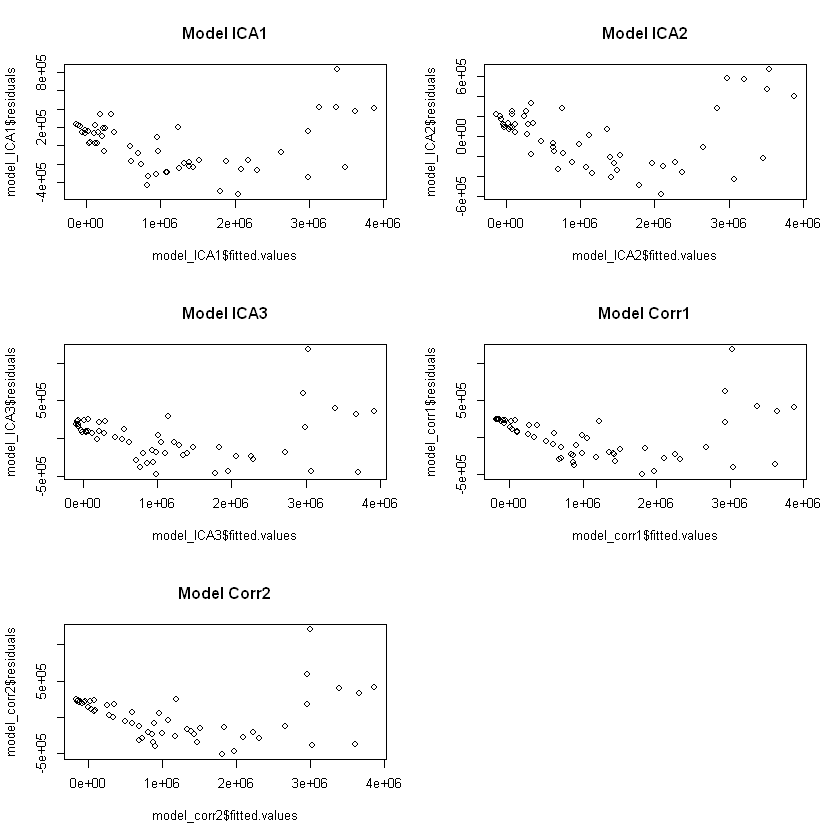

In [319]:
# Plot residuals for all models
par(mfrow=c(3, 2))  # Set up plot layout
plot(model_ICA1$residuals ~ model_ICA1$fitted.values, main="Model ICA1")
plot(model_ICA2$residuals ~ model_ICA2$fitted.values, main="Model ICA2")
plot(model_ICA3$residuals ~ model_ICA3$fitted.values, main="Model ICA3")
plot(model_corr1$residuals ~ model_corr1$fitted.values, main="Model Corr1")
plot(model_corr2$residuals ~ model_corr2$fitted.values, main="Model Corr2")


For an ideal regression model, the residuals should be randomly distributed around zero, with no visible pattern or structure. However, in none of the plots do we observe randomly distributed residuals; outliers are also apparent. The models created using the correlation coefficient analysis method have more dispersed residuals, but they also exhibit more significant outliers.


# 5.Data Transformation

To create a model with randomly distributed residuals, the decision was made to transform the `TotalCost` variable. Two transformations were applied:
- Logarithm transformation
- Square root transformation

As a result, two additional models were created:
- **model_ICA1_log**
- **model_ICA1_sqrt**


In [320]:
# Apply data transformations for model improvement
data$log_TotalCost <- log(data$TotalCost)
data$sqrt_TotalCost <- sqrt(data$TotalCost)

### 5.1. Building models 'model_ICA1_log' and 'model_ICA1_sqrt'

In [321]:
# Build models with transformed data
model_ICA1_log <- lm(log_TotalCost ~ FuelPrice + LoadFactor + Output + AirlineID + Year, data = data)
model_ICA1_sqrt <- lm(sqrt_TotalCost ~ FuelPrice + LoadFactor + Output + AirlineID + Year, data = data)


In [322]:
summary(model_ICA1_log)
summary(model_ICA1_sqrt)


Call:
lm(formula = log_TotalCost ~ FuelPrice + LoadFactor + Output + 
    AirlineID + Year, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.54760 -0.16795  0.04161  0.17565  0.47807 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.394e+01  5.521e-01  25.253  < 2e-16 ***
FuelPrice    1.726e-07  2.977e-07   0.580  0.56475    
LoadFactor  -1.282e+00  9.102e-01  -1.409  0.16526    
Output       5.327e-01  1.537e-01   3.465  0.00113 ** 
AirlineID   -3.781e-01  4.946e-02  -7.645 7.60e-10 ***
Year         1.362e-01  2.525e-02   5.396 2.07e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.2537 on 48 degrees of freedom
Multiple R-squared:  0.9571,	Adjusted R-squared:  0.9526 
F-statistic: 214.2 on 5 and 48 DF,  p-value: < 2.2e-16



Call:
lm(formula = sqrt_TotalCost ~ FuelPrice + LoadFactor + Output + 
    AirlineID + Year, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-143.424  -43.050   -3.096   40.731  133.785 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.038e+03  1.468e+02   7.069 5.75e-09 ***
FuelPrice    2.027e-04  7.917e-05   2.560   0.0137 *  
LoadFactor  -1.098e+03  2.420e+02  -4.537 3.82e-05 ***
Output       6.565e+02  4.088e+01  16.059  < 2e-16 ***
AirlineID   -6.399e+01  1.315e+01  -4.865 1.27e-05 ***
Year         3.454e+01  6.714e+00   5.144 4.93e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 67.48 on 48 degrees of freedom
Multiple R-squared:  0.9848,	Adjusted R-squared:  0.9832 
F-statistic: 621.7 on 5 and 48 DF,  p-value: < 2.2e-16


### 5.2. Residual analysis for new models

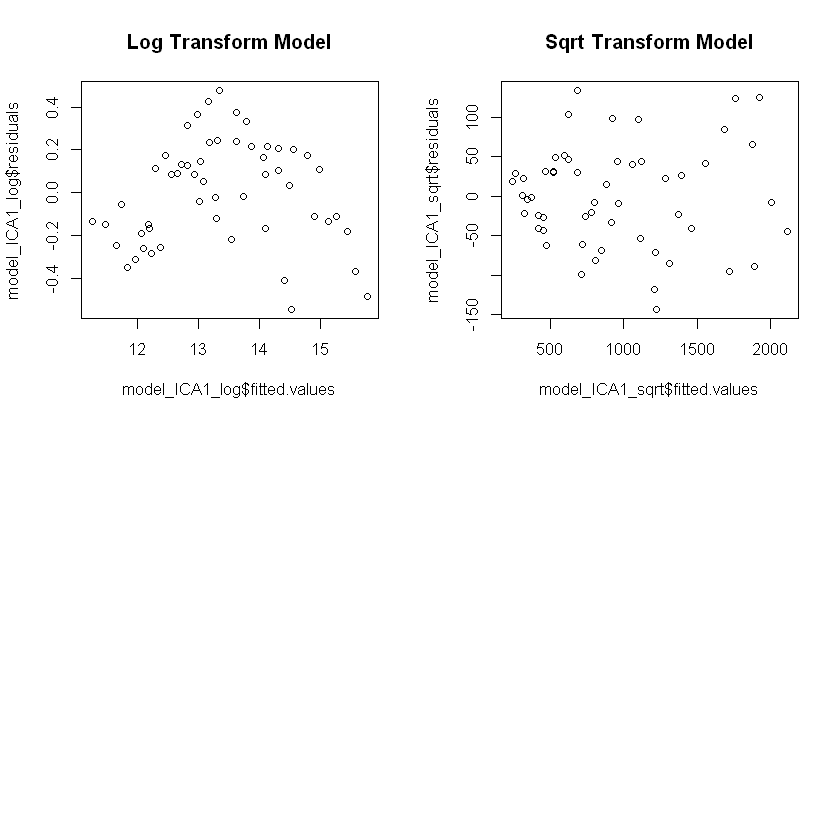

In [323]:
# Plot residuals for the models with transformed data
par(mfrow=c(2, 2))
plot(model_ICA1_log$residuals ~ model_ICA1_log$fitted.values, main="Log Transform Model")
plot(model_ICA1_sqrt$residuals ~ model_ICA1_sqrt$fitted.values, main="Sqrt Transform Model")


The residual analysis of these models showed that the square root transformation, in particular, yielded good results.


### 5.3. Building new models
Next, four additional models were created, this time for the square root transformed `TotalCost` variable:
- **model_ICA2_sqrt**
- **model_ICA3_sqrt**
- **model_corr1_sqrt**
- **model_corr2_sqrt**


In [324]:
# Additional models with square root transformation
model_ICA2_sqrt <- lm(sqrt_TotalCost ~ LoadFactor  + Output + AirlineID + Year, data = data)
model_ICA3_sqrt <- lm(sqrt_TotalCost ~ FuelPrice + Output + AirlineID + Year, data = data)
model_corr1_sqrt <- lm(sqrt_TotalCost ~ Output + FuelPrice, data = data)
model_corr2_sqrt <- lm(sqrt_TotalCost ~ Output + Year + FuelPrice, data = data)


# 6. Model Selection


In [325]:
# Calculate adjusted R-squared, AIC, and BIC for each model
models <- list(
  model_ICA1 = model_ICA1,
  model_ICA2 = model_ICA2,
  model_ICA3 = model_ICA3,
  model_corr1 = model_corr1,
  model_corr2 = model_corr2,
  model_ICA1_sqrt = model_ICA1_sqrt,
  model_ICA2_sqrt = model_ICA2_sqrt,
  model_ICA3_sqrt = model_ICA3_sqrt,
  model_corr1_sqrt = model_corr1_sqrt,
  model_corr2_sqrt = model_corr2_sqrt,
  model_ICA1_log = model_ICA1_log
)

# Create a data frame to store the results
model_comparison <- data.frame(
  Model = names(models),
  Adj_R2 = sapply(models, function(model) summary(model)$adj.r.squared),
  AIC = sapply(models, AIC),
  BIC = sapply(models, BIC)
)

# Print the results in a nicely formatted table
library(knitr)
kable(model_comparison, caption = "Model Comparison: Adjusted R-squared, AIC, and BIC")




Table: Model Comparison: Adjusted R-squared, AIC, and BIC

|                 |Model            |    Adj_R2|        AIC|        BIC|
|:----------------|:----------------|---------:|----------:|----------:|
|model_ICA1       |model_ICA1       | 0.9432322| 1517.30756| 1531.23045|
|model_ICA2       |model_ICA2       | 0.9381925| 1521.01399| 1532.94789|
|model_ICA3       |model_ICA3       | 0.9333603| 1525.07893| 1537.01284|
|model_corr1      |model_corr1      | 0.9328278| 1523.66894| 1531.62488|
|model_corr2      |model_corr2      | 0.9316740| 1525.51929| 1535.46421|
|model_ICA1_sqrt  |model_ICA1_sqrt  | 0.9832099|  615.75692|  629.67981|
|model_ICA2_sqrt  |model_ICA2_sqrt  | 0.9813067|  620.66870|  632.60260|
|model_ICA3_sqrt  |model_ICA3_sqrt  | 0.9764992|  633.02744|  644.96134|
|model_corr1_sqrt |model_corr1_sqrt | 0.9697295|  644.85736|  652.81329|
|model_corr2_sqrt |model_corr2_sqrt | 0.9722514|  641.09068|  651.03560|
|model_ICA1_log   |model_ICA1_log   | 0.9526266|   12.76886|   

### Best model - **model_ICA1_sqrt**
The **model_ICA1_sqrt** was selected as the best model based on the above parameters (highest adjusted R-squared value (0.983) and the lowest AIC (615.8) and BIC (629.7) values).


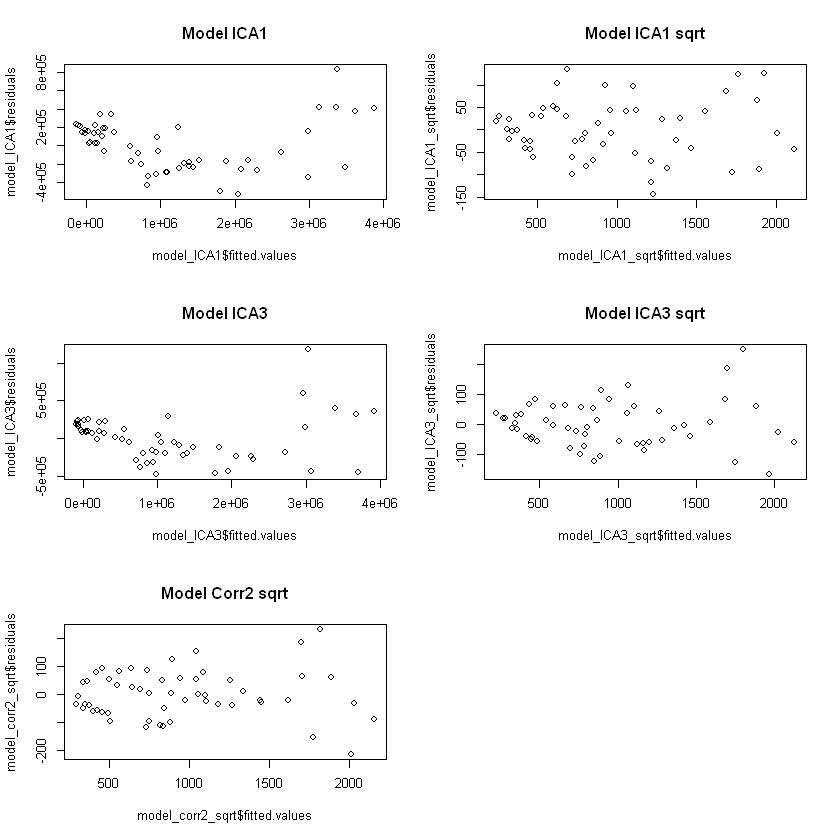

In [326]:
# Plot residuals for each model
par(mfrow=c(3, 2))  # Set up the layout for 3x2 plots
plot(model_ICA1$residuals ~ model_ICA1$fitted.values, main="Model ICA1")
plot(model_ICA1_sqrt$residuals ~ model_ICA1_sqrt$fitted.values, main="Model ICA1 sqrt")
plot(model_ICA3$residuals ~ model_ICA3$fitted.values, main="Model ICA3")
plot(model_ICA3_sqrt$residuals ~ model_ICA3_sqrt$fitted.values, main="Model ICA3 sqrt")
plot(model_corr2_sqrt$residuals ~ model_corr2_sqrt$fitted.values, main="Model Corr2 sqrt")


# 7. Model Verification

The model verification was conducted in 5 steps:
* Normality
* Randomness of residuals
* Autocorrelation
* Symmetry
* Homoscedasticity


In [327]:
# Select the model for further analysis
model <- model_ICA1_sqrt
summary(model)


Call:
lm(formula = sqrt_TotalCost ~ FuelPrice + LoadFactor + Output + 
    AirlineID + Year, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-143.424  -43.050   -3.096   40.731  133.785 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.038e+03  1.468e+02   7.069 5.75e-09 ***
FuelPrice    2.027e-04  7.917e-05   2.560   0.0137 *  
LoadFactor  -1.098e+03  2.420e+02  -4.537 3.82e-05 ***
Output       6.565e+02  4.088e+01  16.059  < 2e-16 ***
AirlineID   -6.399e+01  1.315e+01  -4.865 1.27e-05 ***
Year         3.454e+01  6.714e+00   5.144 4.93e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 67.48 on 48 degrees of freedom
Multiple R-squared:  0.9848,	Adjusted R-squared:  0.9832 
F-statistic: 621.7 on 5 and 48 DF,  p-value: < 2.2e-16


## 7.1. Normality

The Shapiro-Wilk test was conducted to assess the normality of the residuals.


In [328]:
# Shapiro-Wilk test for normality of residuals
shapiro_test <- shapiro.test(residuals(model))
print(shapiro_test)


	Shapiro-Wilk normality test

data:  residuals(model)
W = 0.9867, p-value = 0.8092



A high value of the W statistic, along with a p-value above the 0.05 threshold, does not provide sufficient evidence to reject the null hypothesis (H0) of normality.


## 7.2. Randomness of Residuals

The runs test was conducted to assess the randomness of the residuals.


In [329]:
# Randomness of residuals - Runs test
residuals_factor <- factor(ifelse(residuals(model) > 0, "TRUE", "FALSE"))
runs_test <- runs.test(residuals_factor)
print(runs_test)


	Runs Test

data:  residuals_factor
Standard Normal = -0.54012, p-value = 0.5891
alternative hypothesis: two.sided



 Based on this test, there is no evidence to suggest that the residuals from the model are random.

## 7.3. Autocorrelation

The Durbin-Watson test was conducted to check for autocorrelation in the residuals.

In [330]:
#  Durbin-Watson test for autocorrelation of residuals
dw_test <- dwtest(model)
cat("Durbin-Watson test p-value:", dw_test$p.value, "\n")

Durbin-Watson test p-value: 0.2343706 


Based on the Durbin-Watson test, there is no statistically significant evidence of first-order autocorrelation in the model's residuals.

## 7.4 Symmetry

The symmetry of the residuals was examined.

Skewness of residuals: 0.06559736 


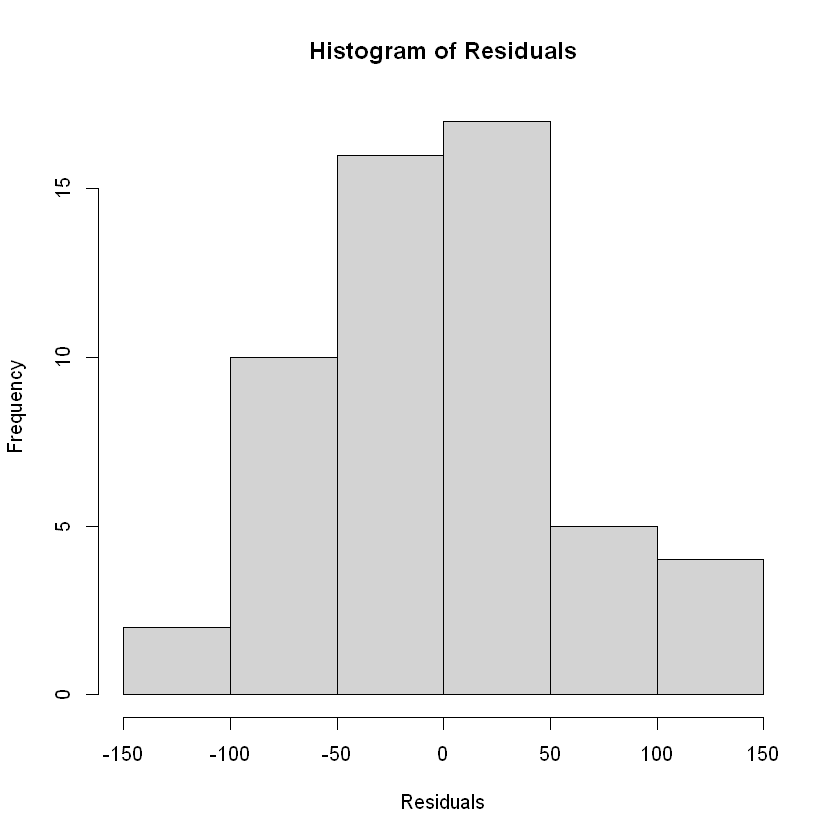

In [331]:
# Check for skewness (symmetry of residuals)
hist(residuals(model), main="Histogram of Residuals", xlab="Residuals")
skewness_res <- skewness(residuals(model))
cat("Skewness of residuals:", skewness_res, "\n")



The skewness of the residuals was calculated to be 0.0656, indicating that the residuals are nearly symmetric. The histogram of residuals also supports this conclusion, showing a fairly symmetric distribution around zero.


## 7.5 Homoscedasticity

The Spearman rank correlation test was conducted to check for the presence of homoscedasticity.


In [332]:
# Check for homoscedasticity using Spearman's rank correlation
spearman_test <- cor.test(fitted(model), residuals(model), method = "spearman")
print(spearman_test)


	Spearman's rank correlation rho

data:  fitted(model) and residuals(model)
S = 27530, p-value = 0.7223
alternative hypothesis: true rho is not equal to 0
sample estimates:
        rho 
-0.04936154 



The results of the Spearman rank correlation test indicate that there is no statistically significant correlation between the fitted values and the residuals in the model. This is a positive outcome, as it suggests that the residuals are independent of the predicted values.

# 8. Prediction

In [333]:
# Make predictions on the test set
predictions <- predict(model, newdata = test_df)

In [334]:
# Compare predictions with actual values
comparison <- data.frame(Real = test_df$sqrt_TotalCost, Predicted = predictions)
print(comparison)

        Real Predicted
8  1521.4335 1571.3235
15 2179.0640 2243.1960
5  1294.8861 1298.9599
22 1225.2959 1205.7292
28 1928.1442 1795.0136
16  754.5144  768.3254
43 1046.9336 1150.5688
34  612.0417  588.1449
38  818.1265  858.2997
56  938.3166  830.9307
51  611.5072  565.4220
59 1141.6611 1034.9099
70  597.4236  612.7071
68  458.4888  489.0146
69  523.4730  494.3132
82  380.8701  438.3821
81  364.9123  414.1537
84  446.9620  488.1536


### RMSE and MAPE

To more accurately assess the model's fit quality, the RMSE (Root Mean Square Error) and MAPE (Mean Absolute Percentage Error) were calculated.

In [335]:
# Calculate RMSE (Root Mean Square Error)
rmse <- sqrt(mean((comparison$Real - comparison$Predicted)^2))
cat("RMSE:", rmse, "\n")

RMSE: 63.3935 


In [336]:
# Calculate MAPE (Mean Absolute Percentage Error)
mape <- mean(abs((comparison$Real - comparison$Predicted) / comparison$Real)) * 100
cat("MAPE:", mape, "%\n")

MAPE: 6.472811 %


The RMSE of 63.3935 suggests a moderate level of prediction error, which should be evaluated in the context of the scale of the dependent variable. On the other hand, the MAPE of 6.472811% indicates a good level of prediction accuracy, as the model predicts the values with an average percentage error of approximately 6.47%. Overall, the model demonstrates a satisfactory fit, particularly in terms of percentage accuracy, but there may still be room for improvement depending on the RMSE relative to the scale of the data.

### Plot real vs predicted

`geom_smooth()` using formula = 'y ~ x'


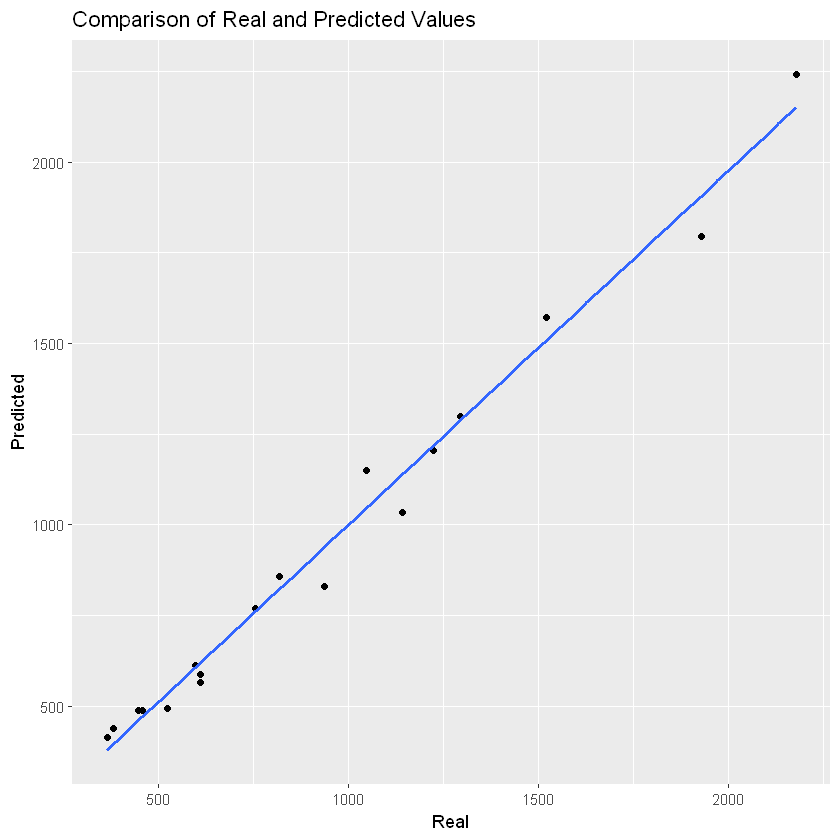

In [337]:
# Plot comparison of real vs predicted values
library(ggplot2)
ggplot(comparison, aes(x = Real, y = Predicted)) +
  geom_point() +
  geom_smooth(method = "lm", se = FALSE) +
  labs(x = "Real", y = "Predicted", title = "Comparison of Real and Predicted Values")


### Plot error (residuals) for each observation

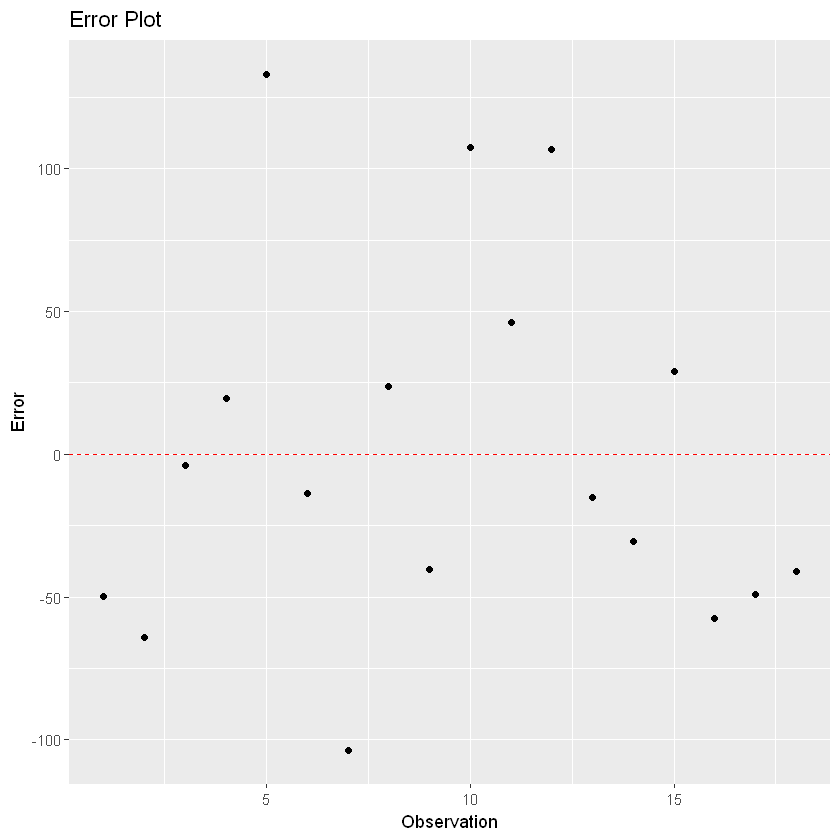

In [339]:
# Plot the error (residuals) for each observation
comparison$error <- comparison$Real - comparison$Predicted
ggplot(comparison, aes(x = 1:nrow(comparison), y = error)) +
  geom_point() +
  geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
  labs(x = "Observation", y = "Error", title = "Error Plot")


In [340]:
# Display the summary of the selected model
summary(model)


Call:
lm(formula = sqrt_TotalCost ~ FuelPrice + LoadFactor + Output + 
    AirlineID + Year, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-143.424  -43.050   -3.096   40.731  133.785 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.038e+03  1.468e+02   7.069 5.75e-09 ***
FuelPrice    2.027e-04  7.917e-05   2.560   0.0137 *  
LoadFactor  -1.098e+03  2.420e+02  -4.537 3.82e-05 ***
Output       6.565e+02  4.088e+01  16.059  < 2e-16 ***
AirlineID   -6.399e+01  1.315e+01  -4.865 1.27e-05 ***
Year         3.454e+01  6.714e+00   5.144 4.93e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 67.48 on 48 degrees of freedom
Multiple R-squared:  0.9848,	Adjusted R-squared:  0.9832 
F-statistic: 621.7 on 5 and 48 DF,  p-value: < 2.2e-16


### Final Regression Model Equation

The final regression model, based on the given summary, is:

$$
\sqrt{TotalCost} = 10380 + 2.027 \times FuelPrice - 3.169 \times LoadFactor + 656.5 \times Output - 63.99 \times AirlineID + 34.54 \times Year
$$

Where:
- **TotalCost** is the dependent variable (after square root transformation).
- **FuelPrice**, **LoadFactor**, **Output**, **AirlineID**, and **Year** are the independent variables.


# 9. Summary

In this analysis, we constructed an econometric model to predict the `TotalCost` variable for different airlines over a 15-year period. Throughout the process, we developed multiple models and applied several methods to select the best one.

1. **Data Preparation**:
    - The dataset contained variables such as `Year`, `AirlineID`, `TotalCost`, `Output`, `FuelPrice`, and `LoadFactor`.
    - The data was divided into a training set (80%) and a test set (20%) to ensure that the model could generalize well to unseen data.

2. **Variable Selection Methods**:
    - We used the **Information Capacity Analysis (ICA)** method, which led to the creation of several initial models, including `model_ICA1`, `model_ICA2`, and `model_ICA3`.
    - **Correlation Coefficient Analysis** was also conducted twice to refine the selection of explanatory variables, resulting in additional models.

3. **Data Transformation**:
    - To improve model accuracy, the dependent variable `TotalCost` was transformed using square root and logarithmic transformations.
    - This transformation led to the creation of models like `model_ICA1_sqrt` and `model_ICA1_log`.

4. **Model Selection**:
    - **`model_ICA1_sqrt`** was identified as the best model based on its high adjusted R-squared value (0.9832) and the lowest AIC and BIC values, indicating a good fit to the data.
    - The selected model included the variables `FuelPrice`, `LoadFactor`, `Output`, `AirlineID`, and `Year` as predictors.

5. **Model Testing**:
    - The model was subjected to several diagnostic tests:
        - **Shapiro-Wilk Test** confirmed the normality of residuals.
        - **Runs Test** and **Durbin-Watson Test** indicated no significant evidence of non-randomness or first-order autocorrelation in the residuals.
        - **Spearman Rank Correlation Test** confirmed homoscedasticity, showing no significant correlation between the residuals and the fitted values.
        - **Skewness Analysis** indicated that the residuals were nearly symmetric.
    - The model's predictive accuracy was evaluated using RMSE (63.3935) and MAPE (6.472811%), indicating that the model performs well in predicting `TotalCost`.

6. **Conclusions**:
    - The **`model_ICA1_sqrt`** was selected as the best model due to its strong fit and robustness, as indicated by the high adjusted R-squared and low prediction errors.
    - The low MAPE suggests that the model provides accurate predictions with an average percentage error of around 6.47%.
    - The diagnostic tests confirm that the model's assumptions were mostly met, indicating that the model is reliable for predicting `TotalCost`.


Overall, the analysis successfully identified a robust model for predicting airline costs, with diagnostic checks confirming the reliability of the selected model. The model's good performance suggests it could be useful for practical applications in the field.
